## Subset sampling for GHZ state preparation circuit

In [1]:
import pecos as pc
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import math
from scipy.special import factorial, erfinv # vectorized factorial function

**1. Direct (Naive) Monte Carlo approach**

CPU times: user 18.1 s, sys: 746 ms, total: 18.9 s
Wall time: 17.8 s


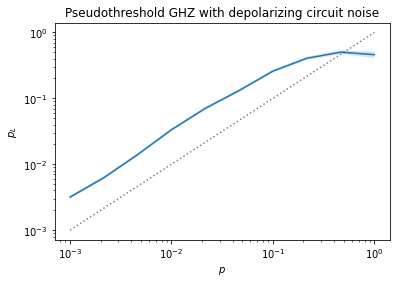

In [59]:
%%time

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
depolar_gen = pc.error_gens.DepolarGen(model_level='circuit')

def MC(p, n_samples):
    logical_errs = 0
    for _ in range(n_samples):
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, ghz, error_gen=depolar_gen, error_params={'p':p})
        if msmt: 
            logical_errs += 1
    return logical_errs

def MC_gen_p_L(p_phy, sample_range):
    p_L= np.empty_like(p_phy)
    for i, p in enumerate(p_phy):
        n_fails = MC(p, sample_range[i])
        p_L[i] = n_fails / sample_range[i]
    p_L_err = np.sqrt(p_L*(1-p_L)/sample_range)
    return p_L, p_L_err

p_phy = np.logspace(-3, 0, 10) # evenly spaced samples in log space
n_samples = 100
sample_range = np.int_(n_samples / p_phy) # take more samples for lower p_phy
p_L, p_L_err = MC_gen_p_L(p_phy, sample_range)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
plt.plot(p_phy, p_L)
plt.fill_between(p_phy, p_L-p_L_err, p_L+p_L_err, alpha=0.2)
plt.plot(p_phy, p_phy, 'k:', alpha=0.5)

**2. Subset sampling approach**

[0.    0.478]
[0.    0.474 0.522]
CPU times: user 427 ms, sys: 36.6 ms, total: 464 ms
Wall time: 420 ms


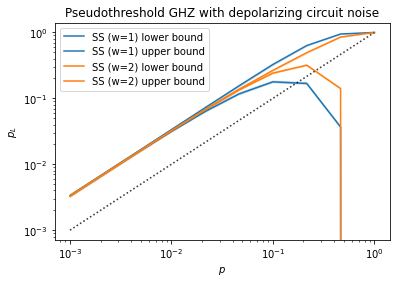

In [10]:
%%time

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(it.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

def subset_sample(ref_circuit, subset_weight, n_samples):
    logical_fails = 0
    for _ in range(n_samples):
        
        # 1. Generate a subset circuit, place random faults at w gates
        subset_circuit = ref_circuit.copy()
        fault_locs = np.random.choice(len(subset_circuit), subset_weight, replace=False)
        for loc in fault_locs:
            for sym, qbs, params in subset_circuit[loc].items():
                if sym in two_qb_gates: 
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            subset_circuit.insert(loc, ({fault: {qb}}, {}))
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    subset_circuit.insert(loc, ({fault: qbs}, {}))
                    
        # 2. Simuluate a circuit run with |00..0> and measure in Z
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, subset_circuit)
        
        # 3.Count logical failures
        if msmt: logical_fails += 1
        
    return logical_fails

n_samples = 1000 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates
n_gates = len(ghz) # number of gates in reference circuit

def SS_gen_p_L_w(w_max, p_phy, n_samples):
    # Subset logical failure rates: Weight-0 faults have failure rate 0.
    p_L_w = np.array([0] + [subset_sample(ghz,w,n_samples)/n_samples for w in range(1,w_max+1)])

    # Binomial weight: Tot. probability of sampling weight-w circuits from all possible circuits
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.array([[A_w(p,w,n_gates) for p in p_phy] for w in range(w_max+1)])

    # Overall bounded logical failure rates
    p_L_low = np.sum(A * p_L_w[:,None], axis=0)
    p_L_up = p_L_low + 1 - np.sum(A, axis=0)

    # Subset and overall standard deviations
    e_SS_w = lambda p, n: np.sqrt( (p * (1-p)) / n )
    e_SS = np.sqrt( np.sum((A[1:] * e_SS_w(p_L_w[1:,None], n_samples))**2, axis=0) )
    return p_L_low, p_L_up, e_SS

cols = ['tab:blue', 'tab:orange']
w_max = 2 # gate fault cutoff
for col, w_m in zip(cols,range(1,w_max+1)):
    p_L_low, p_L_up, e_SS = SS_gen_p_L_w(w_m, p_phy, n_samples)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$p$')
    plt.ylabel(r'$p_L$')
    plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
    plt.plot(p_phy, p_L_low, c=col, label="SS (w=%s) lower bound" % w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, alpha=0.2, color=col)
    plt.plot(p_phy, p_L_up, label="SS (w=%s) upper bound" % w_m, c=col)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, alpha=0.2, color=col)
    plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.legend()

**--- Define global functions & variables ---**

In [4]:
from functools import partial

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))
depolar_gen = pc.error_gens.DepolarGen(model_level='circuit')

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})
n_gates = len(ghz)

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(it.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

def logical_failure_rate_MC(ref_circuit, error_gen, p_phy, n_samples, max_err=0.0):
    logical_fails = 0
    for _ in range(n_samples):
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, ref_circuit, error_gen=error_gen, error_params={"p":p_phy})
        if msmt: logical_fails += 1
        p_L = logical_fails / n_samples
        p_L_err = np.sqrt(p_L*(1-p_L)/n_samples)
        rel_err = p_L_err / p_L if p_L != 0 else 1 # don't break until we have a non-zero p_L
        if rel_err < max_err: break # only sample until target rel. error of 5%
    return p_L, p_L_err

def subset_failure_rate(ref_circuit, subset_weight, n_samples):
    logical_fails = 0
    for _ in range(n_samples):

        # 1. Generate a subset circuit, place random faults at w gates
        subset_circuit = ref_circuit.copy()
        fault_locs = np.random.choice(len(subset_circuit), subset_weight, replace=False)
        offset = 0
        for loc in fault_locs:
            for sym, qbs, params in subset_circuit[loc].items():
                if sym in two_qb_gates: 
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            subset_circuit.insert(loc+offset, ({fault: {qb}}, {}))
                            offset += 1
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    subset_circuit.insert(loc+offset, ({fault: qbs}, {}))
                    offset += 1

        # 2. Simuluate a circuit run with |00..0> and measure in Z
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, subset_circuit)

        # 3.Count logical failures
        if msmt: logical_fails += 1

    return logical_fails / n_samples
    
def logical_failure_rate_SS(ref_circuit, w_max, p_phys, n_samples):

    # generate subset failure rates
    subset_failure_rates = np.array([0] + [subset_failure_rate(ref_circuit, w, n_samples) for w in range(1,w_max+1)])

    # Binomial weight: Tot. probability of sampling weight-w circuits from all possible circuits
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.array([[A_w(p_phy,w,n_gates) for p_phy in p_phys] for w in range(w_max+1)])

    # Overall bounded logical failure rates
    p_L_low = np.sum(A * subset_failure_rates[:,None], axis=0)
    p_L_up = p_L_low + 1 - np.sum(A, axis=0)

    # Subset and overall standard deviations
    e_SS_w = lambda p, n: np.sqrt( (p * (1-p)) / n )
    e_SS = np.sqrt( np.sum((A[1:] * e_SS_w(subset_failure_rates[1:,None], n_samples))**2, axis=0) )
    return p_L_low, p_L_up, e_SS

logical_failure_rate_MC = partial(logical_failure_rate_MC, ghz.copy(), depolar_gen)
logical_failure_rate_SS = partial(logical_failure_rate_SS, ghz.copy())

**3. Comparison plot**

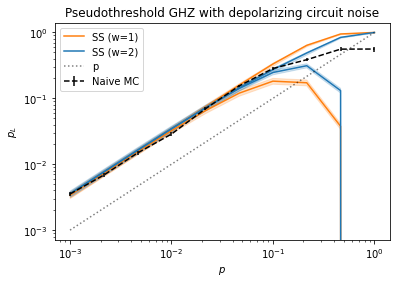

CPU times: user 19.2 s, sys: 376 ms, total: 19.6 s
Wall time: 19 s


In [4]:
%%time

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

n_samples = 100 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates

# Plot SS
for col, w_m in zip(['tab:orange', 'tab:blue'],[1,2]):
    p_L_low, p_L_up, e_SS = logical_failure_rate_SS(w_m,p_phy,n_samples)
    plt.plot(p_phy, p_L_low, c=col, label="SS (w=%s)"%w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, color=col, alpha=0.2)
    plt.plot(p_phy, p_L_up, c=col)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, color=col, alpha=0.2)
    
# Plot MC    
p_L_MC, err_MC = [],[]
n_samples = 100
sample_range = np.int_(n_samples / p_phy) # take more samples for lower p_phy
for p, n_samples_MC in zip(p_phy,sample_range):
    p_L, err = logical_failure_rate_MC(p, n_samples_MC)
    p_L_MC.append(p_L)
    err_MC.append(err)
plt.errorbar(p_phy, p_L_MC, fmt='--', c="black", yerr=err_MC, label="Naive MC")

plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()
plt.show()

**3.1. Behavior for increasing w_max $\rightarrow$ n_gates**

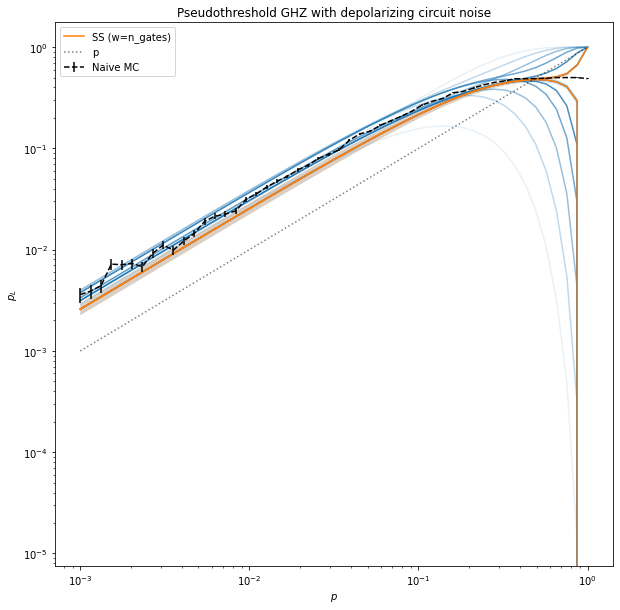

CPU times: user 1min 11s, sys: 802 ms, total: 1min 12s
Wall time: 1min 11s


In [5]:
%%time

plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

n_samples = 100 # number of samples per subset
p_phy = np.logspace(-3, 0, 50) # physical error rates
alphas = np.linspace(0.1, 1, n_gates-1) # increase opacity

for alpha, w_m in zip(alphas, range(1,n_gates)):
    p_L_low, p_L_up, e_SS = logical_failure_rate_SS(w_m,p_phy,n_samples)
    plt.plot(p_phy, p_L_low, c='tab:blue', alpha=alpha)
    plt.plot(p_phy, p_L_up, c='tab:blue', alpha=alpha)

plt.plot(p_phy, p_L_low, c='tab:orange', label="SS (w=n_gates)")
plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, alpha=0.2)
plt.plot(p_phy, p_L_up, c='tab:orange')
plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, alpha=0.2)

n_samples_MC = 10_000
# Plot MC    
p_L_MC, err_MC = [],[]
for p in p_phy:
    p_L, err = logical_failure_rate_MC(p, n_samples_MC, max_err=0.01)
    p_L_MC.append(p_L)
    err_MC.append(err)
plt.errorbar(p_phy, p_L_MC, fmt='--', c="black", yerr=err_MC, label="Naive MC")
plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()
plt.show()

**3.1.1. Bounding behavior for small p**

CPU times: user 1h 21min 56s, sys: 1min 36s, total: 1h 23min 33s
Wall time: 1h 21min 29s


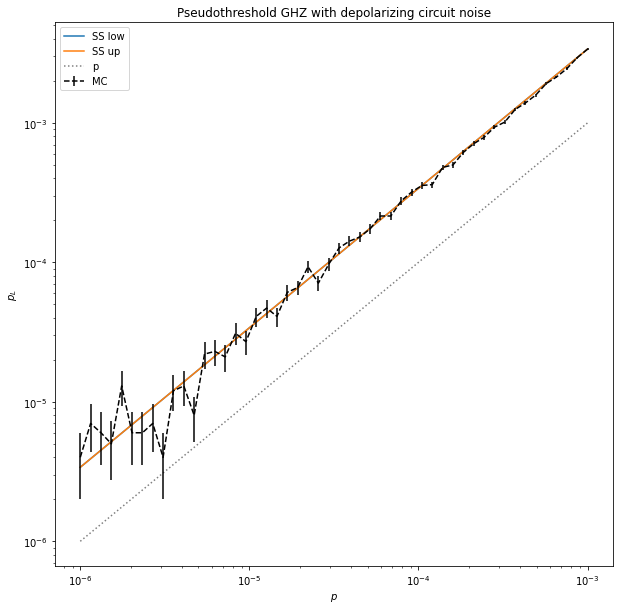

In [36]:
%%time

p_phys = np.logspace(-6, -3, 50) # physical error rates
w_max = 3
n_samples_SS = int(1e3) # Fixed number of samples for subset sampling
n_samples_MC = int(1e6) # Fixed max. number of samples for MC
p_L_low, p_L_up, err_SS = logical_failure_rate_SS(w_max, p_phys, n_samples_SS)

p_L_MC, err_MC = [], []
for p_phy in p_phys:
    p_L, err = logical_failure_rate_MC(p_phy, n_samples_MC, max_err=0.01)
    p_L_MC.append(p_L)
    err_MC.append(err)

plt.figure(figsize=(10,10))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')
plt.plot(p_phys, p_L_low, c='tab:blue', label="SS low")
plt.fill_between(p_phy, p_L_low-err_SS, p_L_low+err_SS, alpha=0.2)
plt.plot(p_phys, p_L_up, c='tab:orange', label="SS up")
plt.fill_between(p_phy, p_L_up-err_SS, p_L_up+err_SS, alpha=0.2)
plt.errorbar(p_phys, p_L_MC, fmt='--', c="black", yerr=err_MC, label="MC")
plt.plot(p_phys, p_phys, 'k:', alpha=0.5, label="p")
plt.legend()

**3.2. Behavior of bound difference $\delta(p)=p_L^{(up)}-p_L^{(low)}$ for varying p and sample size**<br>
* Amount of samples does not impact $\delta$ much.
* This confirms what we theoretically would expect: $\delta=1-\sum_w^{w_{max}}{A_w(p)}$ is independent of sample size.

CPU times: user 27.6 s, sys: 105 ms, total: 27.7 s
Wall time: 27.5 s


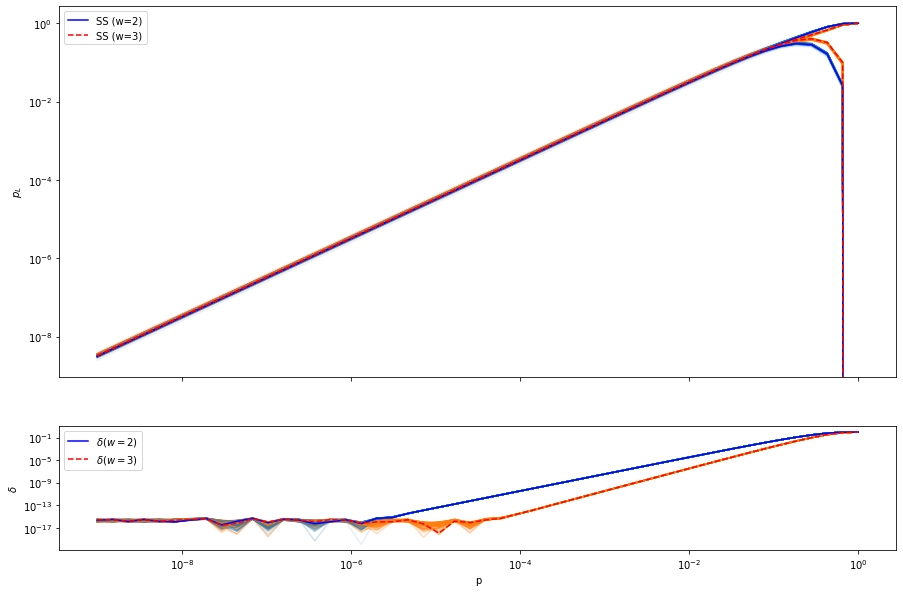

In [3]:
%%time

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10), gridspec_kw={'height_ratios': [3,1]})

samples = np.arange(10, 1000, 10)
alphas = [i*0.5/len(samples) for i in range(len(samples))]
p_phy = np.logspace(-9, 0, 50) # physical error rates
# alpha=0.1
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_ylabel(r'$p_L$')
ax[1].set_xlabel('p')
ax[1].set_ylabel(r'$\delta$')

for (alpha,n_samples) in zip(alphas,samples):
    p_L_low1, p_L_up1, _ = logical_failure_rate_SS(2,p_phy,n_samples)
    ax[0].plot(p_phy, p_L_low1, c='tab:blue', alpha=alpha)
    ax[0].plot(p_phy, p_L_up1, c='tab:blue', alpha=alpha)
    p_L_low2, p_L_up2, _ = logical_failure_rate_SS(3,p_phy,n_samples)
    ax[0].plot(p_phy, p_L_low2, c='tab:orange', alpha=alpha)
    ax[0].plot(p_phy, p_L_up2, c='tab:orange', alpha=alpha)
    
    diff_low = abs(p_L_up1-p_L_low1)
    diff_up = abs(p_L_up2-p_L_low2)
    ax[1].plot(p_phy, diff_low, c='tab:blue', alpha=alpha)
    ax[1].plot(p_phy, diff_up, c='tab:orange', alpha=alpha)

ax[0].plot(p_phy, p_L_low1, c='blue', label='SS (w=2)')
ax[0].plot(p_phy, p_L_up1, c='blue')
ax[0].plot(p_phy, p_L_low2, '--', c='red', label='SS (w=3)')
ax[0].plot(p_phy, p_L_up2, '--', c='red')
ax[0].legend()

ax[1].plot(p_phy, diff_low, c='blue', label=r'$\delta (w=2)$')
ax[1].plot(p_phy, diff_up, '--', c='red', label=r'$\delta (w=3)$')
ax[1].legend()

It looks like $\delta$ saturates at a value of the order $10^{-15}$ for small $p$. Can we consider $\delta=0$ at this scale?<br>
Looking at the sum of all binomial weights, we would expect it to **always** yield 1..

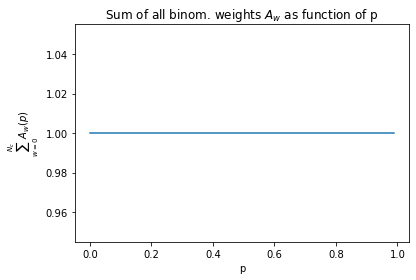

In [146]:
# Note: Have to include all w=0 to 7 terms. 
n_gates = len(ghz)
A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
y = [np.sum([A_w(p,w,n_gates) for w in range(n_gates+1)]) for p in ps]
plt.title("Sum of all binom. weights $A_w$ as function of p")
plt.xlabel("p")
plt.ylabel("$\sum_{w=0}^{N_c}{A_w(p)}$")
plt.plot(ps, y)

.. however, looking closer, we can again see that this is only correct up to order $10^{-15}$. A $\delta$ at this scale must be considered 0.

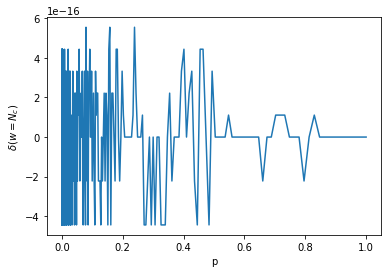

In [4]:
n_gates = len(ghz)
A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
delta = lambda p: 1 - np.sum([A_w(p, w, n_gates) for w in range(n_gates+1)])
x = np.logspace(-9,0,1000)
y = [delta(p) for p in x]
plt.plot(x,y)
plt.xlabel('p')
plt.ylabel(r'$\delta(w=N_c)$')
plt.show()

**3.2.1. Next, we look at the convergence of two $p_L$-curves for different $w_{max}$ values.**<br>
* We plot $A_3(p)p_{3}=p_L^{(3)}(p) - p_L^{(2)}(p)$, with $p_L^{w_{max}}=\sum_{w}^{w_{max}}{A_w(p)p_w}$ and $A_w$, $p_w$ being the binomial coefficient and the subset failure rate for a weight-w subset, respectively. 

CPU times: user 785 ms, sys: 36.1 ms, total: 821 ms
Wall time: 760 ms


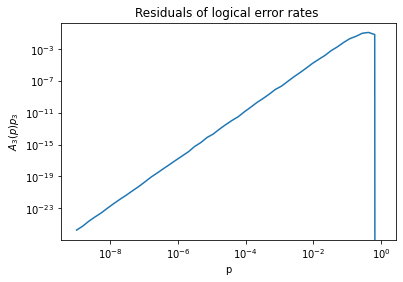

In [5]:
%%time

A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
n_gates = len(ghz) # number of gates in reference circuit
p_phy = np.logspace(-9, 0, 50) # physical error rates
n_samples = 100

diff = []
for p in p_phy:
    diff.append(A_w(p, 3, n_gates) * subset_failure_rate(ghz, 3, n_samples))

plt.title("Residuals of logical error rates ")
plt.xlabel(r'p')
plt.ylabel(r'$A_3(p)p_3$')
plt.yscale('log')
plt.xscale('log')
plt.plot(p_phy, diff)

In the limit of small p the two estimators of the logical failure rate $p_L^{(2)}$ and $p_L^{(3)}$ become almost identical.<br>
Now, we can also show that this is equally valid even for small sample sizes per subset:

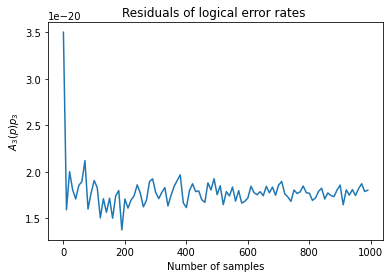

CPU times: user 7.02 s, sys: 130 ms, total: 7.15 s
Wall time: 6.91 s


In [6]:
%%time

A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
n_gates = len(ghz) # number of gates in reference circuit
p_phy = 1e-7 # fix physical error rate
samples = np.arange(1, 1000, 10) # increasing no. of samples

diff = []
for n_samples in samples:
    diff.append(A_w(p_phy, 3, n_gates) * subset_failure_rate(ghz, 3, n_samples))

plt.title("Residuals of logical error rates ")
plt.xlabel('Number of samples')
plt.ylabel(r'$A_3(p)p_3$')
plt.plot(samples, diff)
plt.show()

**3.2.2. Combining the above, we can find $w_{max}$, the SS sampling cutoff for a given tolarated bound difference $\delta_{max}$ at physical error rates $p_{max}$**<br>

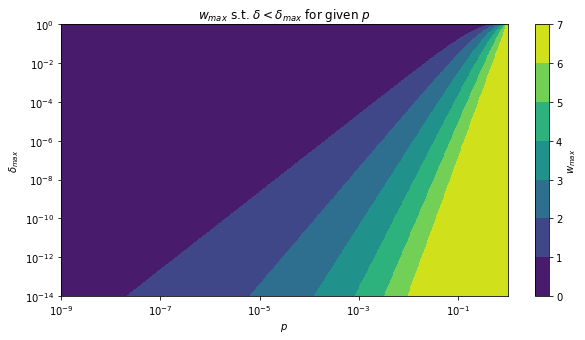

CPU times: user 1.09 s, sys: 95.2 ms, total: 1.19 s
Wall time: 984 ms


In [84]:
%%time

n_gates = len(ghz)
A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)

def adaptive_weight(delta_max, p_max):
    delta = 1
    for w in range(n_gates+1):
        delta -= A_w(p_max, w, n_gates)
        if delta < delta_max: break
    return w

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)
Z = np.array([[adaptive_weight(delta, p_max) for p_max in ps] for delta in ds])

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_max$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()

**4. Next, let's implement both the traditional (naive) and subset sampling (SS) approach allowing to specify multiple physical error rates $p_i$ for different circuit elements.**<br>
* Used references: https://arxiv.org/pdf/1702.01155.pdf and https://arxiv.org/pdf/1801.07035.pdf

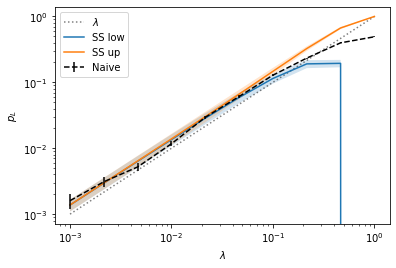

CPU times: user 7.78 s, sys: 104 ms, total: 7.89 s
Wall time: 7.64 s


In [62]:
%%time

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})
n_gates = len(ghz)
n_qbs = 5

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(it.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

all_gate_locs = list(range(n_gates)) 
one_qb_gate_locs = [i for i, (sym, _, _) in enumerate(ghz.items()) if sym in one_qb_gates]
two_qb_gate_locs = [i for i, (sym, _, _) in enumerate(ghz.items()) if sym in two_qb_gates]

def apply_faults_at_locs(circuit, fault_locs):
    err_circuit = pc.error_gens.ErrorCircuits()
    for loc in fault_locs:
        for sym, qbs, params in circuit[loc].items():
            if sym in two_qb_gates: 
                faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                for fault, qb in zip(faults, list(*qbs)):
                    if fault != "I": 
                        err_circuit.add_circuits(loc, after_faults=pc.circuits.QuantumCircuit([{fault: {qb}}]))
            elif sym in one_qb_gates: 
                fault = np.random.choice(one_qb_errs)
                err_circuit.add_circuits(loc, after_faults=pc.circuits.QuantumCircuit([{fault: qbs}]))
    return err_circuit

def sample(n_samples, random_ids_fn, idss, ks, circuit=ghz):
    logical_fails = 0
    for _ in range(n_samples):
        r_ids = list(it.chain.from_iterable([random_ids_fn(k, ids) for k, ids in zip(ks, idss)])) # list of random ids in circuit
        err_circuit = apply_faults_at_locs(circuit, r_ids) # generate error circuit
        sim = pc.simulators.SparseSim(n_qbs) # init new state
        msmt, _ = circ_runner.run(sim, circuit, error_circuits=err_circuit) # run sim, get measurement
        if msmt: logical_fails += 1 # detect logical failures
    return logical_fails / n_samples # return subset failure rate p_L

def p_w(ws, idss, n_samples, circuit=ghz):
    """Function to calculate subset failure rate.
    args:
        ws: list of subset weights
        idss: list of lists of circuit ids corresponding to a subset
        n_samples: no. of samples for MC loop
        circuit: circuit to augment with errors and to use in the simulation.
    """
    logical_fails = 0
    random_ids_fn = lambda w, ids: list(np.random.choice(ids, w, replace=False)) # select w distinct random elements from list
    return sample(n_samples, random_ids_fn, idss, ws)

def subset_sampler(n_samples, idss, pss, ws):
    
    # Preprocessing
    ws = [ws] if type(ws) != list else ws # allow int value for ws, cast to list
    pss = pss.T if pss.ndim > 1 else pss # for multi-dim. case transpose for broadcasting in A_w
    ns = np.array( [len(idx) for idx in idss] ) # amounts of gates for each subcircuit (idss)
    
    # Create weight vectors, calculate subset error rates and binom. coefficients
    nCr = lambda n,r: factorial(n) / (factorial(r)*factorial(n-r)) # vectorized combination
    A_w = lambda n,w,p: nCr(n,w) * p**w * (1-p)**(n-w) # vectorized binomial coefficient
    w_vecs = list(it.product( *[list(range(w+1)) for w in ws] )) # all weight vector combinations
    pws = np.array([p_w(w_vec, idss, n_samples) for w_vec in w_vecs])[:,None] # list of subset failure rates (rows)
    As = np.array([A_w(ns,w_vec,pss) for w_vec in w_vecs]) # list of binomial coefficients per p (cols) and w (rows)
    As = np.product(As, axis=-1) if len(ws) > 1 else As # multi-dim. case involves a product over A_w terms

    # Calculate logical error rate and std
    p_L_low = np.sum(As * pws, axis=0) # sum over rows. Final shape: 1d of length pss
    p_L_up = p_L_low + 1 - np.sum(As, axis=0)
    std = np.sqrt( np.sum( As[1:]**2 * (pws[1:] * (1-pws[1:])), axis=0) / n_samples )
    
    return p_L_low, p_L_up, std

def naive_sampler(n_samples, idss, pss):
    
    # preprocessing
    p_Ls = np.zeros(shape=(pss.shape[-1]))
    stds = np.empty_like(p_Ls)
    pss = pss if pss.ndim > 1 else pss[None, :] # for multi-dim case prepare for broadcasting
    pss = pss.T # line up p1,p2,.. in rows
    random_ids_fn = lambda p, ids: [i for i in ids if np.random.random() < p] # uniformly select from ids with probability p
    
    for i, ps in enumerate(pss):
        p_L = sample(n_samples, random_ids_fn, idss, ps)
        p_Ls[i] = p_L
        stds[i] = np.sqrt( p_L * (1-p_L) / n_samples)
        
    return p_Ls, stds

# For multi-dimensional case we have to consider several cases:
# 1. Uniform scaling: Scale all physical error rates by same parameter lambda
# 2. Partial scaling: Scale one physical error rate while keeping others constant
# 3. Individual scaling: Each rate is scaled individually by a lambda_i (ignore for now)

lambdas = np.logspace(-3, 0, 10) # physical error rates
scale = lambda p_init, lambdas=lambdas: p_init * lambdas

# one-dimensional case
# idss = [all_gate_locs]
# ws = 1
# pss = scale(1)
                        
# two-dimensional case
idss = [one_qb_gate_locs, two_qb_gate_locs]
ws = [1,1]
pss = np.array([scale(1), scale(0.5)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$p_L$')
plt.plot(lambdas, lambdas, 'k:', alpha=0.5, label=r"$\lambda$")

n_samples = 20
p_L_low, p_L_up, std = subset_sampler(n_samples, idss, pss, ws)
plt.plot(lambdas, p_L_low, label="SS low")
plt.fill_between(lambdas, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(lambdas, p_L_up, label="SS up")
plt.fill_between(lambdas, p_L_up-std, p_L_up+std, alpha=0.2)

n_samples = 10000
p_L, std = naive_sampler(n_samples, idss, pss)
plt.errorbar(lambdas, p_L, fmt='--', c="black", yerr=std, label="Naive")
plt.legend()
plt.show()

**Let's take a closer look at how the multi-parameter case behaves.**

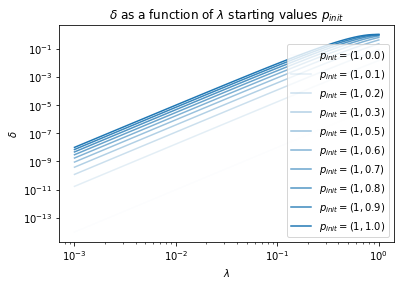

In [3]:
lambdas = np.logspace(-3, 0, 100) # physical error rates
scale = lambda p_init, lambdas=lambdas: p_init * lambdas
idss = [one_qb_gate_locs, two_qb_gate_locs]

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\delta$')

ws = [2,2]
n_samples = 20
for s in np.linspace(1e-2, 1, 10): 
    pss = np.array([scale(1), scale(s)])
    p_L_low, p_L_up, std = subset_sampler(n_samples, idss, pss, ws)
    plt.plot(lambdas, p_L_up - p_L_low, c='tab:blue', alpha=s, label=r'$p_{init}=(1,$%.1f)' % s) 
plt.title(r'$\delta$ as a function of $\lambda$ starting values $p_{init}$')
plt.legend()
plt.show()

**A more modular version of subset sampler**<br>
* Outsource noise model
* Identify and isolate logical code blocks for supporting code modularity<br>

**1) OOP approach: Sampler inheritence and custom error model: Error circuit generation before circuit run**

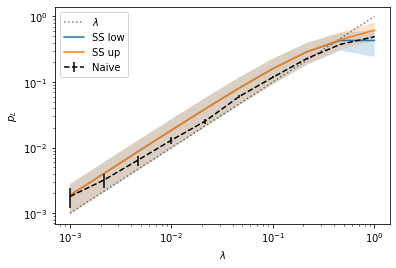

CPU times: user 4.35 s, sys: 109 ms, total: 4.46 s
Wall time: 4.23 s


In [6]:
%%time

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

### Analytics
z = 1.96 # 95% constant confidence interval
Wilson_max = lambda p,N: (p + z**2/(2*N) + z*np.sqrt(p*(1-p)/N+z**2/(4*N**2)))/(1+z**2/N)
Wilson_min = lambda p,N: (p + z**2/(2*N) - z*np.sqrt(p*(1-p)/N+z**2/(4*N**2)))/(1+z**2/N)

Wilson_std = lambda p,N: Wilson_max(p,N) - Wilson_min(p,N)
Wald_std = lambda p,N: np.sqrt(p * (1-p) / N)
# Wald_std = lambda p,N: z * np.sqrt(p * (1-p) / N)

rssp = lambda a,e: np.sqrt(np.sum( (a*e)**2, axis=0 )) # root sum of squared products
stdev = lambda A,p,N, std_type: rssp(A[1:], (Wilson_std if std_type=='Wilson' else Wald_std)(p[1:], N))

nCr = lambda n,r: factorial(n) / (factorial(r)*factorial(n-r)) # Vectorized combination
A_w = lambda n,w,p: nCr(n,w) * p**w * (1-p)**(n-w) # (Binomial) subset probability

### Numerics

def run_circuit(state, circuit, err_circuit=None):
    out = []
    for tick_circuit, tick, _ in circuit.iter_ticks():
        res = state.run_circuit(tick_circuit)
        if res: out.append(res)
        if err_circuit: # All faults are treated as "after" faults here
            state.run_circuit(err_circuit[tick])
    return out
    
class DepolarGen(): # depolar error generator for circuit level noise
    one_qb_errs = ['X','Y','Z']
    two_qb_errs  = list(it.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
    two_qb_errs.remove(('I','I')) # remove II as it is not a fault
    
    def __init__(self, choose_fn, n_ticks):
        self.choose_fn = choose_fn # Naive and Subset sampler error generators differ only by the choose function.
        self.n_ticks = n_ticks
    
    def generate(self, partitions, values):
        err_circ = pc.circuits.QuantumCircuit(self.n_ticks)
        for errs in [self.choose_fn(p,v) for p, v in zip(partitions, values)]: ## WORK WITH DICT AND ADD SELECTION OF ERROR SETS
            for (tick, qbs) in errs:
                if type(qbs) == int:
                    err_circ.update(np.random.choice(self.one_qb_errs), tick=tick, locations={qbs})
                elif type(qbs) == tuple:
                    for (fault, qb) in zip(self.two_qb_errs[np.random.choice(len(self.two_qb_errs))], qbs):
                        if fault != "I":
                            err_circ.update(fault, tick=tick, locations={qb})
        return err_circ
    
class Sampler():
    
    one_qb_gates = {'H'}
    two_qb_gates = {'CNOT'}
    
    def __init__(self, circuit, err_params):
        self.circuit = circuit
        self.n_qbs = len(circuit.qudits)   
        self.partitions = self._partition_circuit(circuit, err_params.keys())
        self.partition_probabilities = self._partition_probability_matrix(err_params.values())
        self.partition_lens = np.array([len(p) for p in self.partitions])
    
    def _partition_circuit(self, circuit, keys):
        # select collection of lists of (tick, qb) tuples representing elements in a circuit partition (i.e. "gate group")
        partitions = {
            "p": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs],
            "p1": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if sym in self.one_qb_gates],
            "p2": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if sym in self.two_qb_gates],
            "p_idle1": [(i, qb) for i in range(len(circuit)) for qb in circuit.qudits.difference(circuit.active_qudits[i]) if list(circuit[i].symbols.keys())[0] in self.one_qb_gates],
            'p_idle2': [(i, qb) for i in range(len(circuit)) for qb in circuit.qudits.difference(circuit.active_qudits[i]) if list(circuit[i].symbols.keys())[0] in self.two_qb_gates],
            "p_init": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if "init" in sym],
            "p_meas": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if "measure" in sym],
            "p_xtalk1": [(i, tuple(qb)[0]+j) for i, qb in enumerate(circuit.active_qudits) for j in [-1, +1] if tuple(qb)[0]+j in circuit.qudits and list(circuit[i].symbols.keys())[0] in self.one_qb_gates],
            "p_xtalk2": [(i, tuple(qb)[-1]+j) for i, qb in enumerate(circuit.active_qudits) for j in [-1, +1] if tuple(qb)[-1]+j in circuit.qudits and list(circuit[i].symbols.keys())[0] in self.two_qb_gates]
        }
        return [partitions[k] for k in keys]
    
    def _partition_probability_matrix(self, vals):
        # generate matrix P of dims (scaling range) x (specified partitions)
        n_partitions = len(vals)
        n_points = max([len(v) if type(v) == np.ndarray else 1 for v in vals])
        P = np.zeros((n_points, n_partitions))
        for i, v in enumerate(vals): 
            P[:,i] = v
        return P
    
    def _sample(self, n_samples, err_gen=None, choice_vector=None):
        logical_fails = 0
        for _ in range(n_samples):
            state = pc.simulators.SparseSim(self.n_qbs)
            err_circuit = None if err_gen == None else err_gen.generate(self.partitions, choice_vector)
            msmt = run_circuit(state, self.circuit, err_circuit)
            logical_fails += self._check_logical_fail(msmt)
        return logical_fails / n_samples
    
    def _check_logical_fail(self, msmt):
        if msmt: return 1
        else: return 0
        
    
class SubsetSampler(Sampler):
    
    def __init__(self, circuit, err_params):
        super().__init__(circuit, err_params)
        choose_fn = lambda l,k: [l[i] for i in np.random.choice(len(l),k,replace=False)]
        self.err_gen = DepolarGen(choose_fn=choose_fn, n_ticks=len(circuit))
            
    def _min_weight(self, p_max, d_max, w_max):
        delta = 1
        for w in range(w_max+1):
            delta -= A_w(w_max, w, p_max)
            if delta < d_max: break
        return w
    
    def run(self, p_max, delta_max, n_samples=20):
        
        # Find w_max vector for delta_max
        assert len(p_max) == len(delta_max) == len(self.partitions)
        w_cutoff = np.zeros_like(p_max, dtype=int)
        for i in range(len(w_cutoff)):
            w_cutoff[i] = self._min_weight(p_max[i], delta_max[i], self.partition_lens[i])
        
        # Generate all weight vector combis from w_max vector
        w_vecs = list(it.product( *[list(range(w_cutoff_i+1)) for w_cutoff_i in w_cutoff] ))

        # Numerical part: Generate 1D list of subset error rates per weight vector combination
        pws = np.array([self._sample(n_samples, self.err_gen, w_vec) for w_vec in w_vecs])[:,None]

        # Analytical part: Calculate 3D tensor of binom. coefs. per weight vector combi, partition & partition probabilities
        As = np.array([A_w(self.partition_lens,w_vec,self.partition_probabilities) for w_vec in w_vecs])
        As = np.product(As, axis=-1) # eliminate last axis by multiplying over it. (Particularly important for multi-p case, for single-p this axis is 1)

        # Calculate statistics
        p_L_low = np.sum(As * pws, axis=0)
        p_L_up = p_L_low + 1 - np.sum(As, axis=0)

        # std = Wilson_stdev(As, pws, n_samples)
        std = stdev(As,pws,n_samples, "Wilson")
                
        return p_L_low, p_L_up, std

class NaiveSampler(Sampler):
    
    def __init__(self, circuit, err_params):
        super().__init__(circuit, err_params)
        choose_fn = lambda l,p: set(i for i in l if np.random.random() < p)
        self.err_gen = DepolarGen(choose_fn=choose_fn, n_ticks=len(circuit))
    
    def run(self, n_samples=100):
        p_L = np.zeros(shape=(self.partition_probabilities.shape[0]))
        std = np.empty_like(p_L)
        for i, p_row in enumerate(self.partition_probabilities):
            p_L[i] = self._sample(n_samples, self.err_gen, p_row)
            std[i] = Wald_std(p_L[i], n_samples)

        return p_L, std

class DynamicSubsetSampler():
    pass

class AdaptiveSampler():
    def __init__(self, circuit, err_params):
        self.subset_sampler = None
        self.naive_sampler = None
        
    def run(self):
        pass # switch between Subset and Naive sampler

lambdas = np.logspace(-3, 0, 10) # physical error rates
scale = lambda p_init, lambdas=lambdas: p_init * lambdas
err_params = {'p1': scale(1), 'p2':scale(0.5)}

sss = SubsetSampler(ghz, err_params)
p_L_low, p_L_up, std = sss.run(p_max=[0.5, 0.5], delta_max=[0.1,0.5], n_samples=20) # TO DO: Easier definition of p_max and d_max.

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$p_L$')
plt.plot(lambdas, lambdas, 'k:', alpha=0.5, label=r"$\lambda$")
plt.plot(lambdas, p_L_low, label="SS low")
plt.fill_between(lambdas, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(lambdas, p_L_up, label="SS up")
plt.fill_between(lambdas, p_L_up-std, p_L_up+std, alpha=0.2)

ns = NaiveSampler(ghz, err_params)
p_L, ns_std = ns.run(n_samples=5000)
plt.errorbar(lambdas, p_L, fmt='--', c="black", yerr=ns_std, label="Naive")
plt.legend()
plt.show()

**Compare Wald interval to Wilson interval**

In [2]:
# some test values
n_samples = 1000
As = np.array([[0.2,0.3],[0.1,0.6]])
pws = np.array([[0.4,0.3],[0.4,0.3]])

# definition of intervals
z = lambda a: np.sqrt(2.0)*erfinv(a/2.0)
q = lambda x,a,N: x / (1 + z(a)**2 / N)
r = lambda a,p,N: z(a)*np.sqrt(p*(1-p)/N + z(a)**2/(4*N))
l = lambda a,p,N: p + z(a)/(2*N)
Wilson_max = lambda a,p,N: q(l(a,p,N) + r(a,p,N), a, N)
Wilson_min = lambda a,p,N: q(l(a,p,N) - r(a,p,N), a, N)

# This gives us epsilon_ss^(w)
Wilson_std = lambda a,p,N: Wilson_max(a,p,N) - Wilson_min(a,p,N)
Wald_std = lambda p,N: np.sqrt( p * (1-p) / N)

std = lambda a,e: np.sqrt(np.sum( (a*e)**2, axis=0 ))

print(std(As, Wald_std(pws,n_samples)))
print(std(As, Wilson_std(As,pws,n_samples)))

[0.0034641  0.00972111]
[0.00080884 0.00745901]


In [5]:
# Check the value of e_SS_w for w = 0
Wilson_std(0.5,0,100)

0.010142806329577696

**2) Functional approach with PECOS error model (error generation during circuit iteration)**
* Here only p1 and p2 implemented. This approach is mostly used for reference and comparison.
* The OOP approach is more clear and more modular, thus the preferred method.

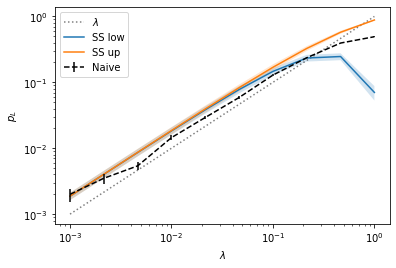

CPU times: user 7.75 s, sys: 146 ms, total: 7.9 s
Wall time: 7.58 s


In [17]:
%%time

circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})
n_gates = len(ghz)
n_qbs = 5

one_qb_gates = {'H'}
two_qb_gates = {'CNOT'}

one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(it.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

all_gate_locs = list(range(n_gates)) 
one_qb_gate_locs = [i for i, (sym, _, _) in enumerate(ghz.items()) if sym in one_qb_gates]
two_qb_gate_locs = [i for i, (sym, _, _) in enumerate(ghz.items()) if sym in two_qb_gates]

class BaseGen():
    
    def __init__(self):
        self.error_ids = {}
        
    def start(self, params, random_ids_fn):
        if len(params) == 1:
            return random_ids_fn(all_gate_locs, params[0])
        elif len(params) == 2:
            ids_1 = random_ids_fn(one_qb_gate_locs, params[0])
            ids_2 = random_ids_fn(two_qb_gate_locs, params[1])
            return ids_1.union(ids_2)
    
    def generate_tick_errors(self, tick_circuit, tick_idx, **params):
        err_circuit = pc.error_gens.ErrorCircuits()
        if tick_idx in self.error_ids:
            for sym, qbs, _ in tick_circuit.circuit[tick_idx].items():
                if sym in two_qb_gates:
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            err_circuit.add_circuits(tick_idx, after_faults=pc.circuits.QuantumCircuit([{fault: {qb}}]))
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    err_circuit.add_circuits(tick_idx, after_faults=pc.circuits.QuantumCircuit([{fault: qbs}]))
        return err_circuit
        
class DepolarGen(BaseGen):
    
    def start(self, circuit, error_params, sim):
        random_ids = lambda ids, p: set(i for i in ids if np.random.random() < p) # uniformly select from ids with probability p
        probs = error_params['p']
        self.error_ids = super().start(probs, random_ids)
    
class ssDepolarGen(BaseGen):

    def start(self, circuit, error_params, sim):
        random_ids = lambda ids, w: set(np.random.choice(ids, w, replace=False))
        weights = error_params['w']
        self.error_ids = super().start(weights, random_ids)

def sample(n_samples, err_gen, err_params, n_qbs=n_qbs, circuit=ghz):
    logical_fails = 0
    for _ in range(n_samples):
        sim = pc.simulators.SparseSim(n_qbs) # init new state
        msmt, _ = circ_runner.run(sim, circuit, error_gen=err_gen, error_params=err_params) # run sim, get measurement
        if msmt: logical_fails += 1 # detect logical failures
    return logical_fails / n_samples # return subset failure rate p_L

def subset_sampler(n_samples, idss, pss, ws):
    
    # Preprocessing
    ws = [ws] if type(ws) != list else ws # allow int value for ws, cast to list
    pss = pss.T if pss.ndim > 1 else pss # for multi-dim. case transpose for broadcasting in A_w
    ns = np.array( [len(idx) for idx in idss] ) # amounts of gates for each subcircuit (idss)
    
    # Create weight vectors, calculate subset error rates and binom. coefficients
    nCr = lambda n,r: factorial(n) / (factorial(r)*factorial(n-r)) # vectorized combination
    A_w = lambda n,w,p: nCr(n,w) * p**w * (1-p)**(n-w) # vectorized binomial coefficient
    w_vecs = list(it.product( *[list(range(w+1)) for w in ws] )) # all weight vector combinations

    pws = np.array([sample(n_samples, ssDepolarGen(), err_params={'w':w_vec}) for w_vec in w_vecs])[:,None] # list of subset failure rates (rows)
    As = np.array([A_w(ns,w_vec,pss) for w_vec in w_vecs]) # list of binomial coefficients per p (cols) and w (rows)
    As = np.product(As, axis=-1) if len(ws) > 1 else As # multi-dim. case involves a product over A_w terms

    # Calculate logical error rate and std
    p_L_low = np.sum(As * pws, axis=0) # sum over rows. Final shape: 1d of length pss
    p_L_up = p_L_low + 1 - np.sum(As, axis=0)
    std = np.sqrt( np.sum( As[1:]**2 * (pws[1:] * (1-pws[1:])), axis=0) / n_samples )
    
    return p_L_low, p_L_up, std

def naive_sampler(n_samples, idss, pss):
    
    # preprocessing
    p_Ls = np.zeros(shape=(pss.shape[-1]))
    stds = np.empty_like(p_Ls)
    pss = pss if pss.ndim > 1 else pss[None, :] # for multi-dim case prepare for broadcasting
    pss = pss.T # line up p1,p2,.. in rows
    
    for i, ps in enumerate(pss):
        p_L = sample(n_samples, DepolarGen(), err_params={'p': ps})
        p_Ls[i] = p_L
        stds[i] = np.sqrt( p_L * (1-p_L) / n_samples)
        
    return p_Ls, stds


lambdas = np.logspace(-3, 0, 10) # physical error rates
scale = lambda p_init, lambdas=lambdas: p_init * lambdas

# one-dimensional case
# idss = [all_gate_locs]
# ws = 1
# pss = scale(1)
                        
# two-dimensional case
idss = [one_qb_gate_locs, two_qb_gate_locs]
ws = [1,1]
pss = np.array([scale(1), scale(0.5)])

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$p_L$')
plt.plot(lambdas, lambdas, 'k:', alpha=0.5, label=r"$\lambda$")

n_samples = 20
p_L_low, p_L_up, std = subset_sampler(n_samples, idss, pss, ws)
plt.plot(lambdas, p_L_low, label="SS low")
plt.fill_between(lambdas, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(lambdas, p_L_up, label="SS up")
plt.fill_between(lambdas, p_L_up-std, p_L_up+std, alpha=0.2)

n_samples = 10000
p_L, std = naive_sampler(n_samples, idss, pss)
plt.errorbar(lambdas, p_L, fmt='--', c="black", yerr=std, label="Naive")
plt.legend()
plt.show()

**4.1. Using the method from 3.2.2 to choose a $w_{max}$ for a tolerated offset $\delta_{max}$ at a rate $p_{max}$ we can develop an algorithm to adaptively switch between SS and naive sampling**

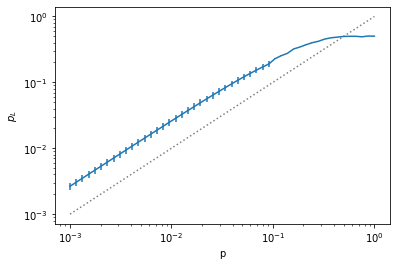

CPU times: user 25.1 s, sys: 124 ms, total: 25.2 s
Wall time: 24.8 s


In [139]:
%%time
nCr = lambda n,r: factorial(n) / (factorial(r)*factorial(n-r)) # vectorized combination
A_w = lambda n,w,p: nCr(n,w) * p**w * (1-p)**(n-w) # vectorized binomial coefficient

n_gates = len(ghz)
idss = [all_gate_locs]
p_phy = np.logspace(-3, 0, 50) # physical error rates
pss = p_phy
ws = 2

def adaptive_weight(delta_max, p_max):
    delta = 1
    for w in range(n_gates+1):
        delta -= A_w(n_gates, w, p_max)
        if delta < delta_max: break
    return w
    
def sample(n_samples, random_ids_fn, idss, ks, circuit=ghz):
    logical_fails = 0
    for _ in range(n_samples):
        r_ids = list(it.chain.from_iterable([random_ids_fn(k, ids) for k, ids in zip(ks, idss)])) # list of random ids in circuit
        err_circuit = apply_faults_at_locs(circuit, r_ids) # generate error circuit
        sim = pc.simulators.SparseSim(n_qbs) # init new state
        msmt, _ = circ_runner.run(sim, circuit, error_circuits=err_circuit) # run sim, get measurement
        if msmt: logical_fails += 1 # detect logical failures
    return logical_fails / n_samples # return subset failure rate p_L

# Preprocessing
p_Ls = np.zeros(shape=(pss.shape[-1]))
stds = np.empty_like(p_Ls)
pss = pss if pss.ndim > 1 else pss[None, :] # for multi-dim case prepare for broadcasting
pss = pss.T # line up p1,p2,.. in rows
random_ids_fn = lambda p, ids: [i for i in ids if np.random.random() < p] # uniformly select from ids with probability p
ws = [ws] if type(ws) != list else ws # allow int value for ws, cast to list
ns = np.array( [len(idx) for idx in idss] ) # amounts of gates for each subcircuit (idss)

# Create weight vectors, calculate subset error rates and binom. coefficients
w_vecs = list(it.product( *[list(range(w+1)) for w in ws] )) # all weight vector combinations
pws = np.array([p_w(w_vec, idss, n_samples) for w_vec in w_vecs])[:,None] # list of subset failure rates (rows)

SS = True
for i, ps in enumerate(pss):
    if SS:
        n_samples = 100
        As = np.array([A_w(ns, w_vec, ps) for w_vec in w_vecs])
        As = np.product(As, axis=-1) if len(ws) > 1 else As # multi-dim. case involves a product over A_w terms
        std = np.sqrt( np.sum( As[1:]**2 * (pws[1:] * (1-pws[1:])), axis=0) / n_samples )
        p_L = np.sum(As * pws, axis=0) # sum over rows. Final shape: 1d of length pss
        
        if adaptive_weight(std, ps[0]) > ws[0]: SS = False # here we make the choice when to switch
    else:
        n_samples = 10000
        p_L = sample(n_samples, random_ids_fn, idss, ps)
        std = np.sqrt( p_L * (1-p_L) / n_samples) 
    p_Ls[i] = p_L
    stds[i] = std
    
plt.xscale('log')
plt.yscale('log')
plt.errorbar(p_phy, p_Ls, yerr=stds)
plt.plot(p_phy, p_phy, 'k:', alpha=0.5)
plt.xlabel('p')
plt.ylabel(r'$p_L$')
plt.show()